In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL.Image import fromarray

In [20]:
samples = ['\anime\1.png'
'\anime\14.png'
'\anime\15.png']


In [23]:
import os
from tensorflow.keras.utils import img_to_array


In [24]:
path = 'anime'

In [25]:
X = []

for img_path in os.listdir(path) :
    if img_path[-3:]   ==  'png' :
        X.append(img_to_array(fromarray(cv2.cvtColor(cv2.imread(os.path.join(path, img_path)), cv2.COLOR_BGR2RGB))))
X = np.array(X)

In [26]:
print(X.shape)

(21551, 64, 64, 3)


In [27]:
X = (X-127.5)/127.5

In [28]:
import tensorflow as tf

In [29]:
BUFFER_SIZE = 1000
BATCH_SIZE  = 128
NOISE_DIM   = 100

In [30]:
train_data = tf.data.Dataset.from_tensor_slices(X).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Sample Visualization

In [31]:
for trainX in train_data.take(1) :
    pass

In [32]:
print(trainX.shape)

(128, 64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

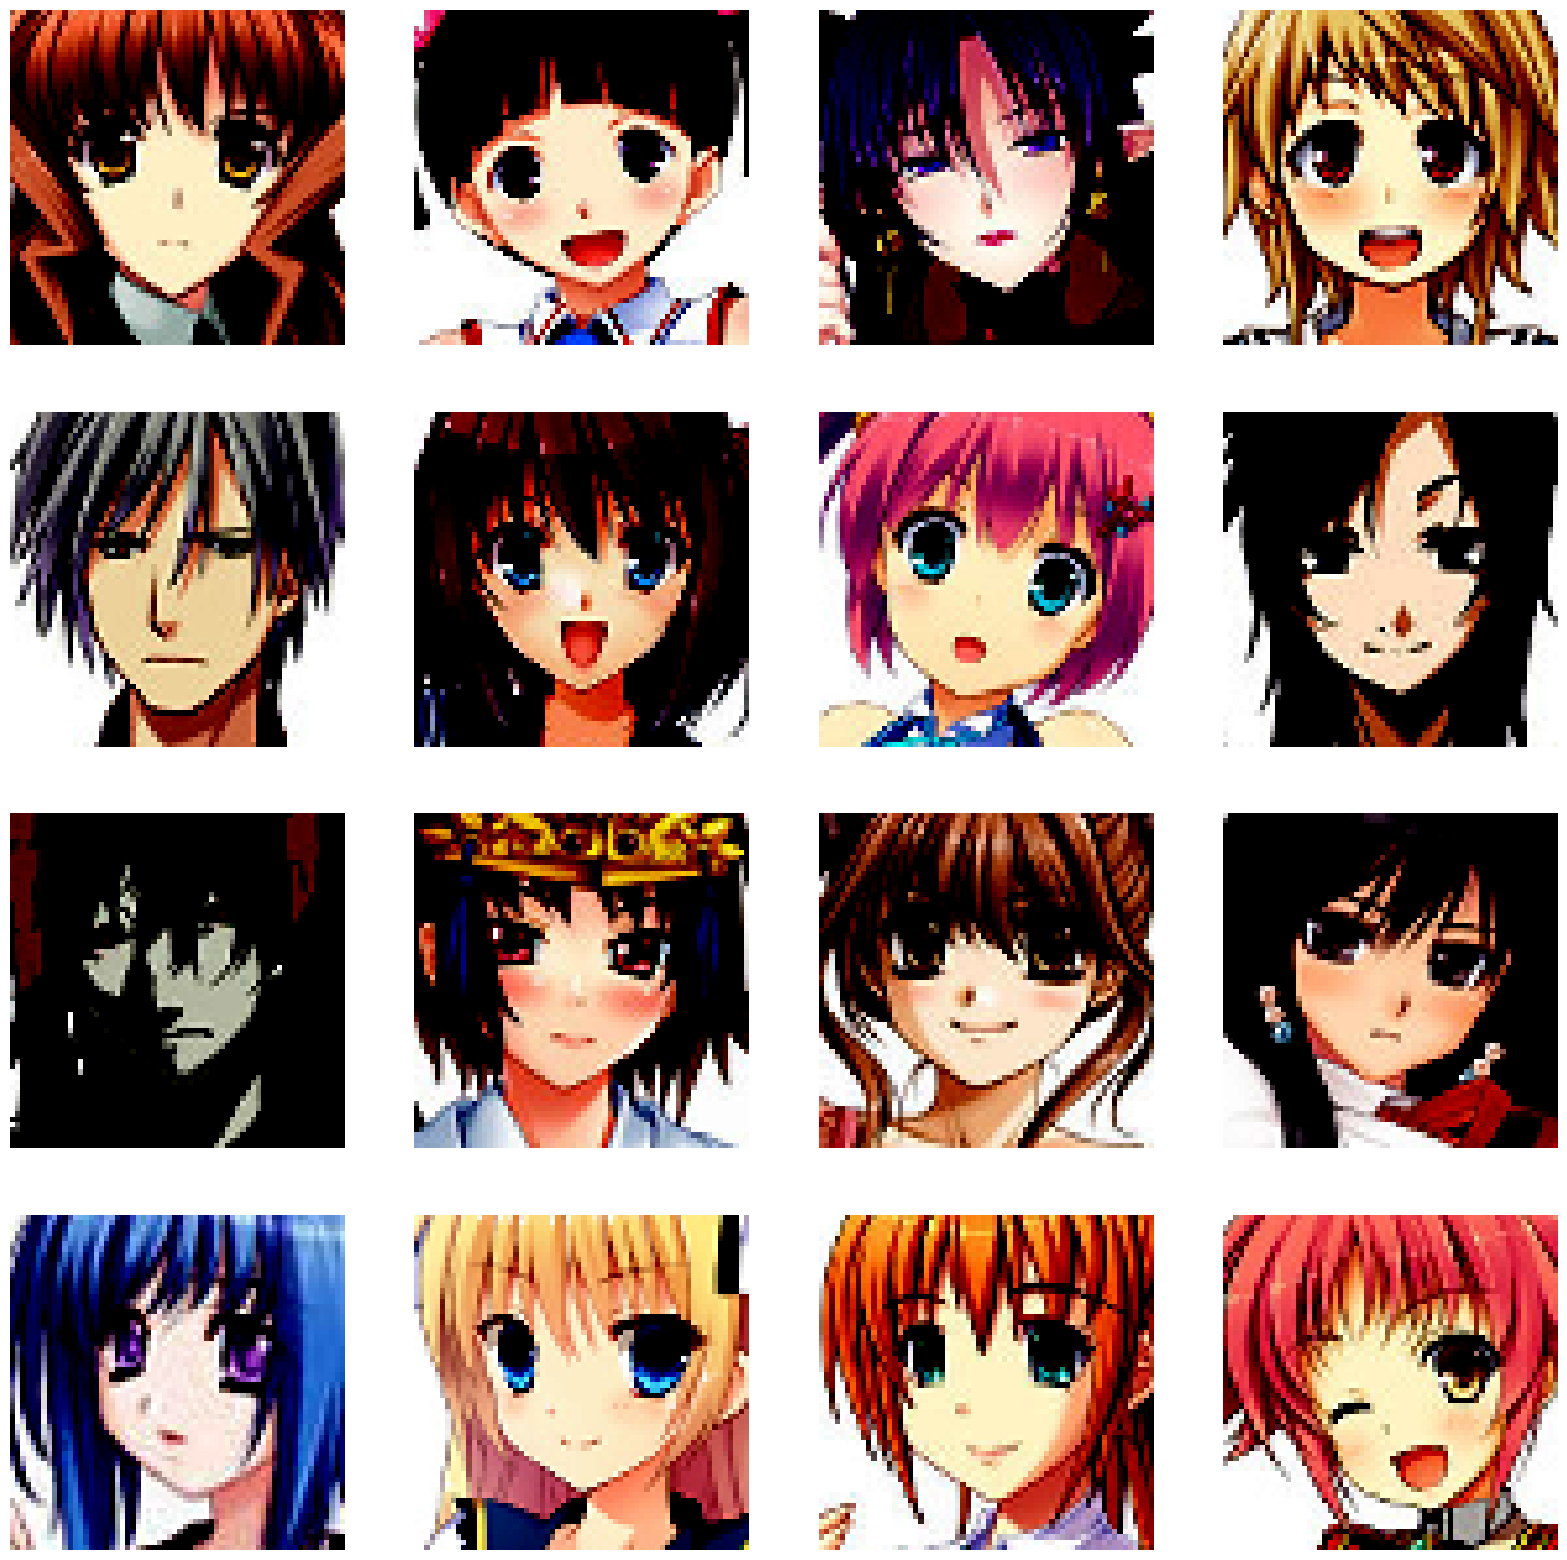

In [33]:
plt.figure(figsize = (20,20))
i = 0

while i < 16 :
    
    plt.subplot(4,4, i+1)
    plt.imshow(trainX[i])
    plt.axis('off')
    i += 1

# Discriminator

In [34]:
from keras.initializers import RandomNormal
from keras.layers import Conv2DTranspose
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization

In [35]:
init = RandomNormal(mean = 0.0, stddev = 0.02)

In [36]:
def conv_layer(filterx,pad,isbatchnorm) :
    
    model = Sequential()
    model.add(Conv2D(filterx, (4,4), strides = 2, padding = pad,
                     use_bias = False, kernel_initializer=init))
    
    if isbatchnorm :
        model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(LeakyReLU())
    
    return model

In [37]:
def dis () :
    
    model = Sequential([
        
        Input((64, 64, 3,)),            # 64x64
        conv_layer(2**7, 'same',False), # 32x32
        conv_layer(2**8, 'same', True), # 16x16
        conv_layer(2**9, 'same', True), # 08x08
        conv_layer(2**10,'same', True), # 04x04
        
        Conv2D(1, (4,4), strides = 2, padding = 'valid', activation = 'sigmoid') # 01x01
    ])
    
    return model

In [38]:
d_model = dis()

c:\Users\ASUS\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [39]:
from keras.utils import plot_model

In [40]:
plot_model(d_model, './dis.png', show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Generator

In [41]:
def tran_layer(filterx,pad,isbatchnorm) :
    
    model = Sequential()
    model.add(Conv2DTranspose(filterx, (4,4), strides = 2, padding = pad,
                              use_bias = False, kernel_initializer=init))
    
    if isbatchnorm :
        model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(ReLU())
    
    return model

In [42]:
def gen () :
    
    model = Sequential([
        
        Input((NOISE_DIM,)),            # 01x01
        
        Dense(1024*4*4, kernel_initializer = init),
        Reshape((4,4,1024)),            # 04x04
        
        tran_layer(2**9, 'same', True), # 08x08
        tran_layer(2**8, 'same', True), # 16x16
        tran_layer(2**7, 'same', True), # 32x32
        Conv2DTranspose(3**1, (4,4), strides = 2, padding = 'same', activation = 'tanh') # 64x64
    ])
    
    return model

In [43]:
g_model = gen()

In [62]:
plot_model(g_model, './gen.png', show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Model Training

In [47]:
bin_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [49]:
'''
Discriminator loss
'''
def d_loss (real_output, fake_output) :
    
    real_loss = bin_entropy(tf.ones_like (real_output), real_output)
    fake_loss = bin_entropy(tf.zeros_like(fake_output), fake_output)
    
    return real_loss + fake_loss

'''
Generator loss
'''
def g_loss (fake_output) :
    
    return bin_entropy(tf.ones_like(fake_output), fake_output)

In [50]:
g_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
d_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

In [51]:
@tf.function
def train_batch (image) :
    
    noise = tf.random.normal([BATCH_SIZE,NOISE_DIM])
    with tf.GradientTape(persistent = True) as tape :
        
        g_img = g_model(noise, training = True)
        real_output = d_model(image, training=True)
        fake_output = d_model(g_img, training=True)
        
        gen_loss = g_loss(fake_output)
        dis_loss = d_loss(real_output, fake_output)
    
    gen_grad = tape.gradient(gen_loss, g_model.trainable_variables)
    dis_grad = tape.gradient(dis_loss, d_model.trainable_variables)
    
    g_optimizer.apply_gradients(zip(gen_grad, g_model.trainable_variables))
    d_optimizer.apply_gradients(zip(dis_grad, d_model.trainable_variables))

In [52]:
def fig_plot (noise) :
    
    gen_img = g_model(noise , training = True)
    
    plt.figure(figsize = (20,20))
    i = 0
    
    plt.subplot(1, 3, i+1)
    plt.imshow(gen_img[0])
    plt.axis('off')
    
    plt.subplot(1, 3, i+2)
    plt.imshow(gen_img[1])
    plt.axis('off')
    
    plt.subplot(1, 3, i+3)
    plt.imshow(gen_img[2])
    plt.axis('off')
    
    plt.show()

def fit (epochs) :
    
    for epoch in range(epochs) :
        
        print(f'{epoch} done out of {epochs}')
        for n, image in train_data.enumerate() :
            if n%4 == 0 :
                print('#', end='')
            train_batch(image)
        print()
        
        if epoch%3 == 0 :
            
            noise = tf.random.normal([3,NOISE_DIM])
            fig_plot(noise)

0 done out of 35
###########################################


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


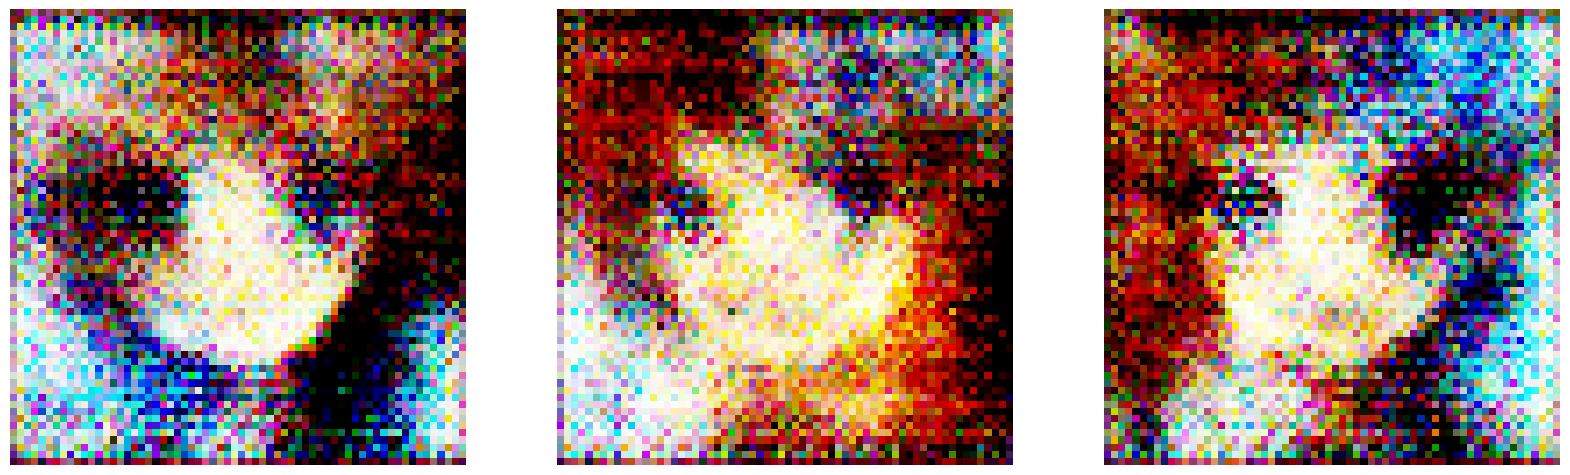

1 done out of 35
###########################################
2 done out of 35
###########################################
3 done out of 35
###########################################


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


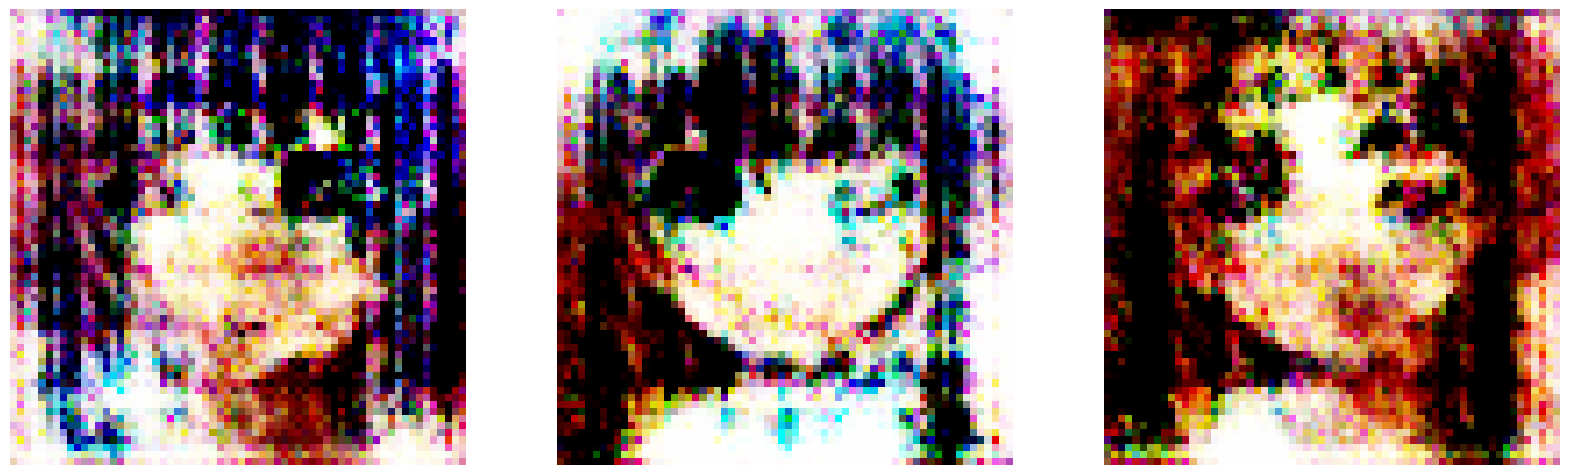

4 done out of 35
###########################################
5 done out of 35
###########################################
6 done out of 35
###########################################

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


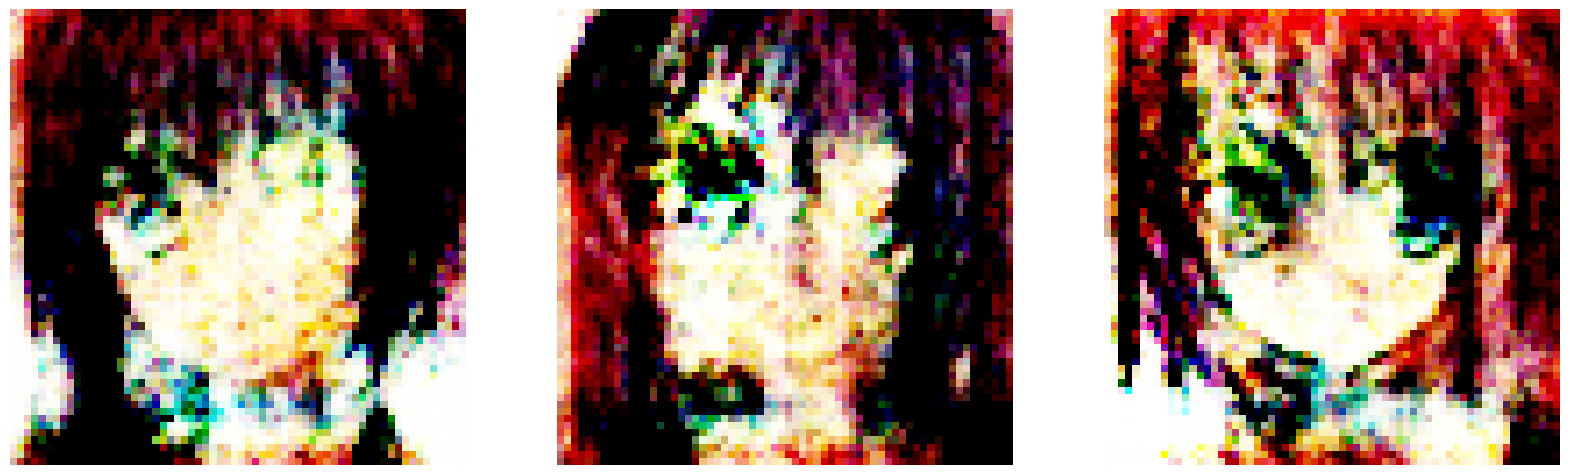

7 done out of 35
###########################################
8 done out of 35
###########################################
9 done out of 35
###########################################

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


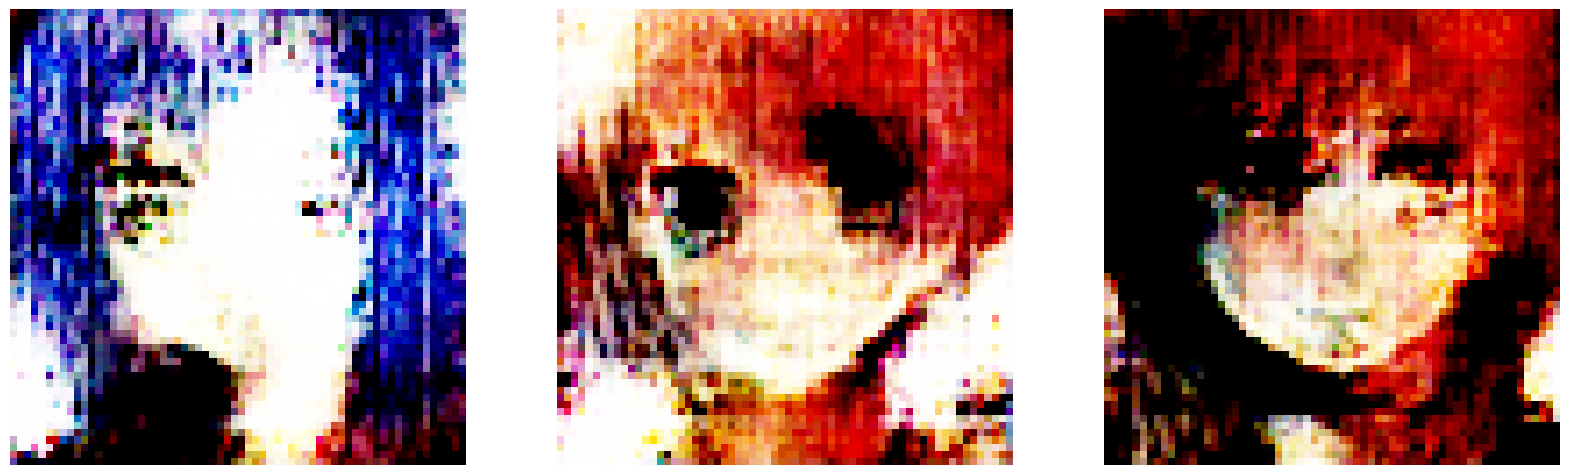

10 done out of 35
###########################################
11 done out of 35
###########################################
12 done out of 35
###########################################

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


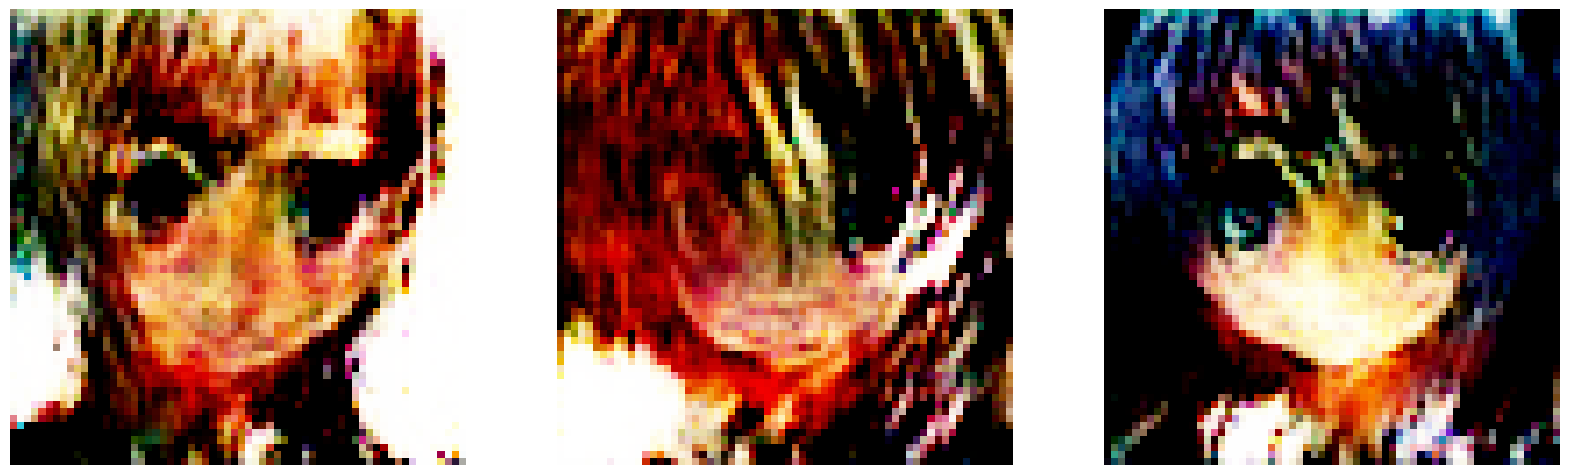

13 done out of 35
###########################################
14 done out of 35
###########################################
15 done out of 35
###########################################

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


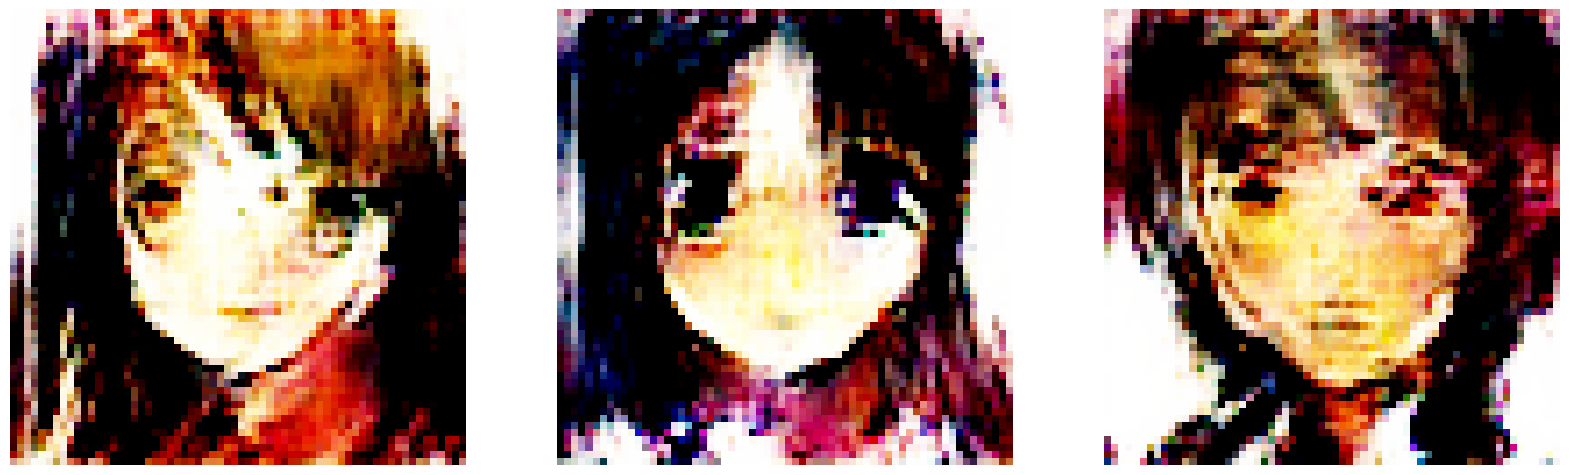

16 done out of 35
###########################################
17 done out of 35
###########################################
18 done out of 35
###########################################

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


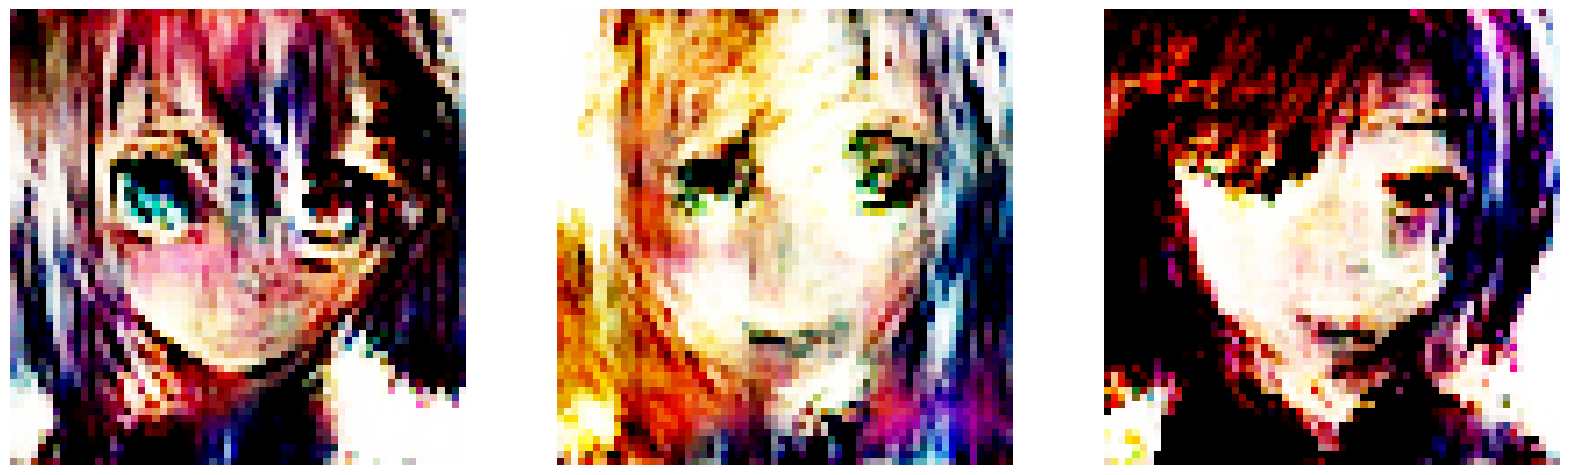

19 done out of 35
###########################################
20 done out of 35
###########################################
21 done out of 35
###########################################

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


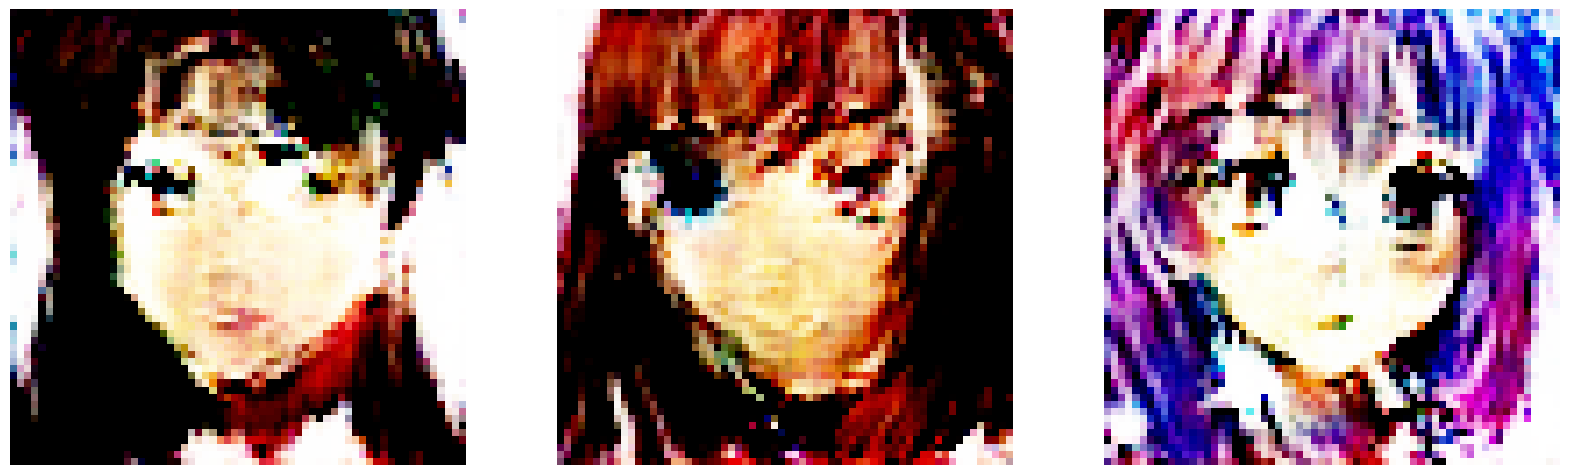

22 done out of 35
###########################################
23 done out of 35
###########################################
24 done out of 35
###########################################

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


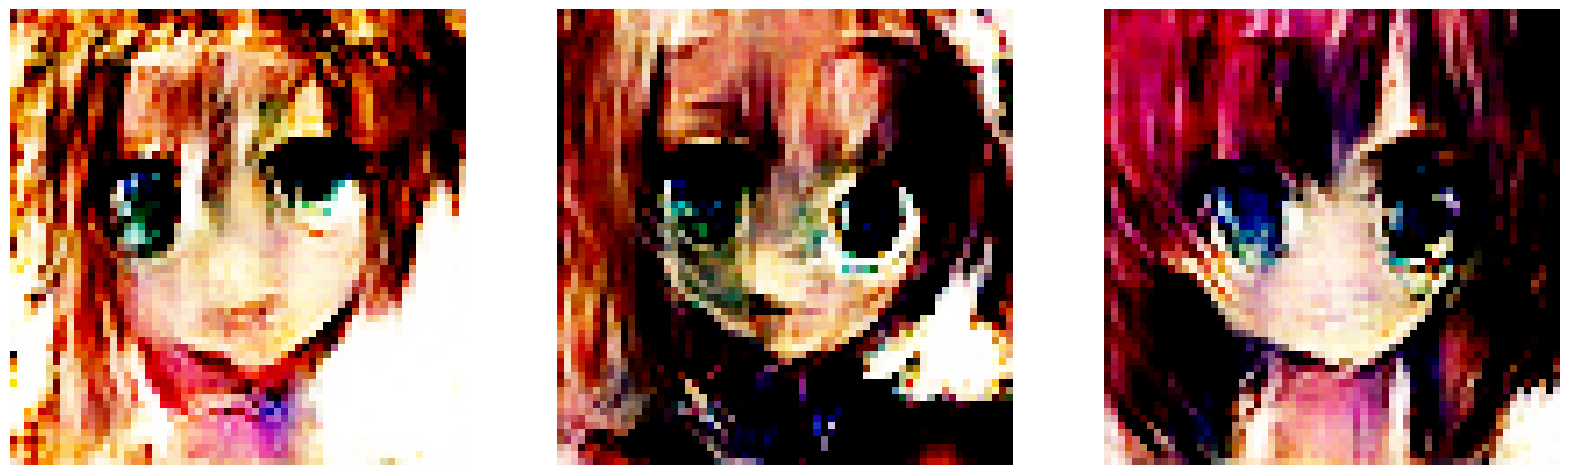

25 done out of 35
###########################################
26 done out of 35
###########################################
27 done out of 35
###########################################


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


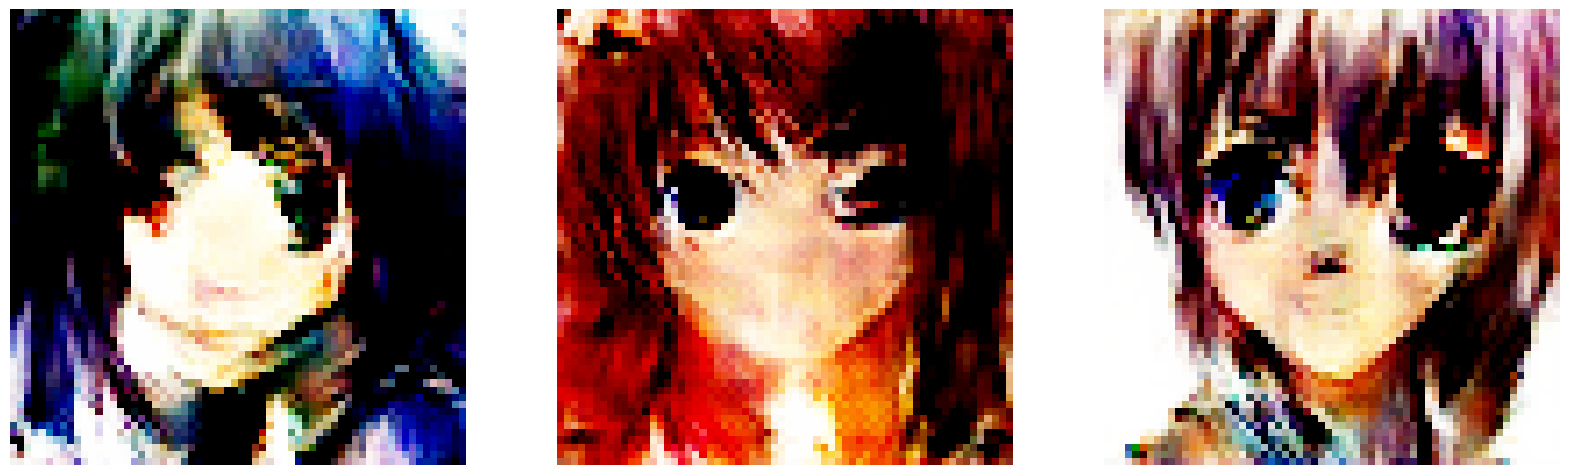

28 done out of 35
###########################################
29 done out of 35
###########################################
30 done out of 35
###########################################

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


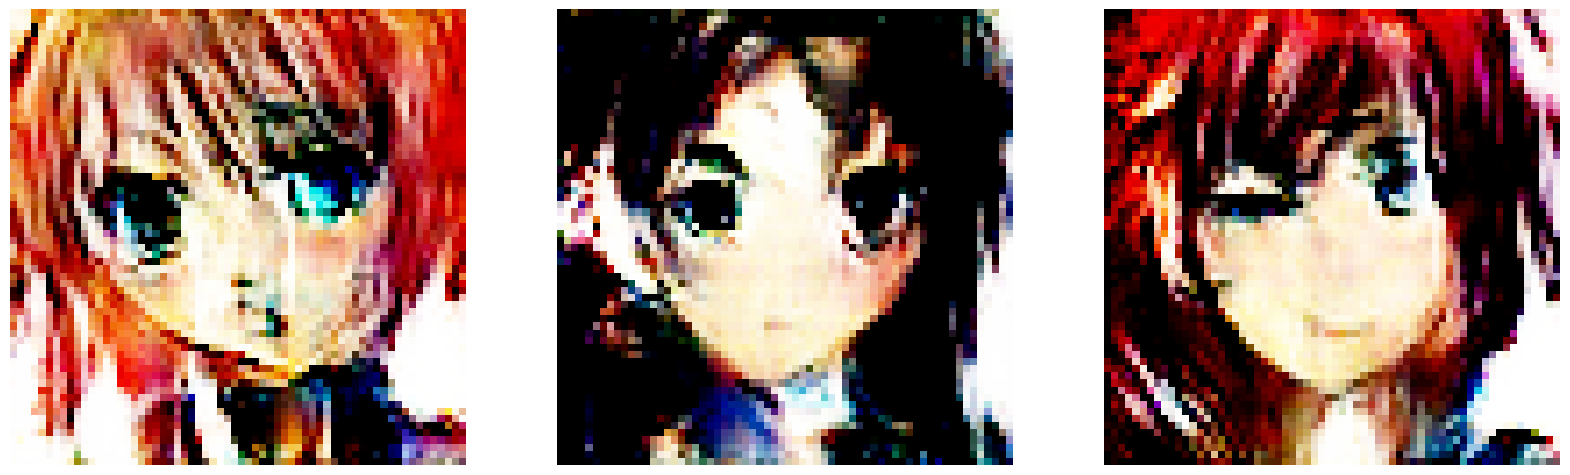

31 done out of 35
###########################################
32 done out of 35
###########################################
33 done out of 35
###########################################

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


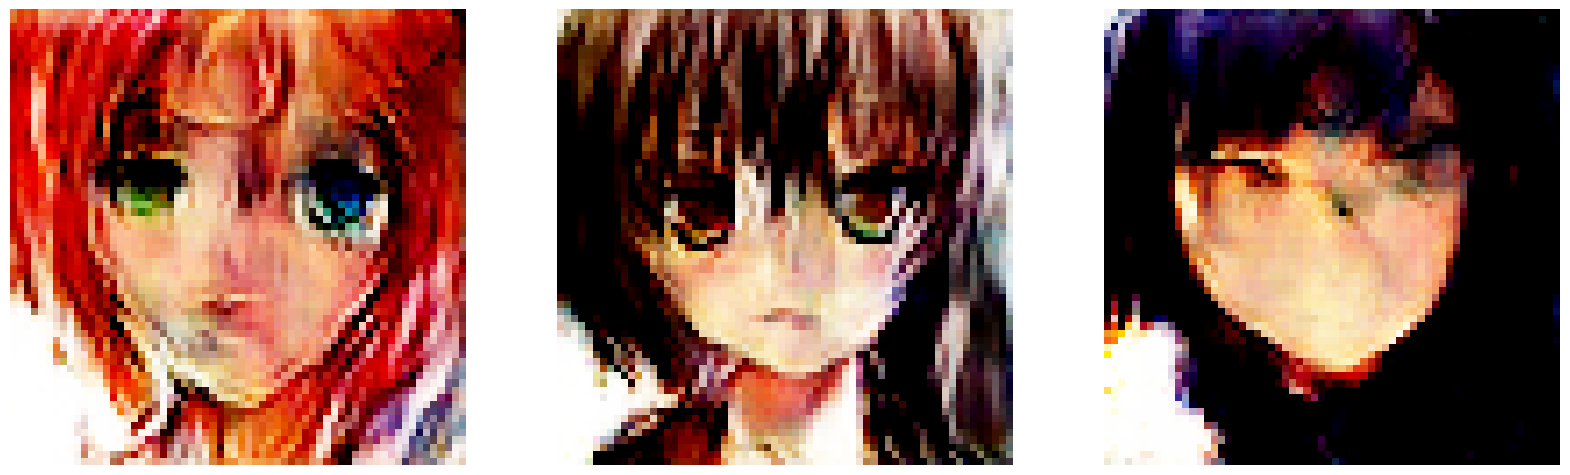

34 done out of 35
###########################################


In [57]:
EPOCHS = 35
fit(EPOCHS)

# Stand-alone Generator Perfromance

In [58]:
gen_img = g_model(tf.random.normal([16, NOISE_DIM]), training = False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

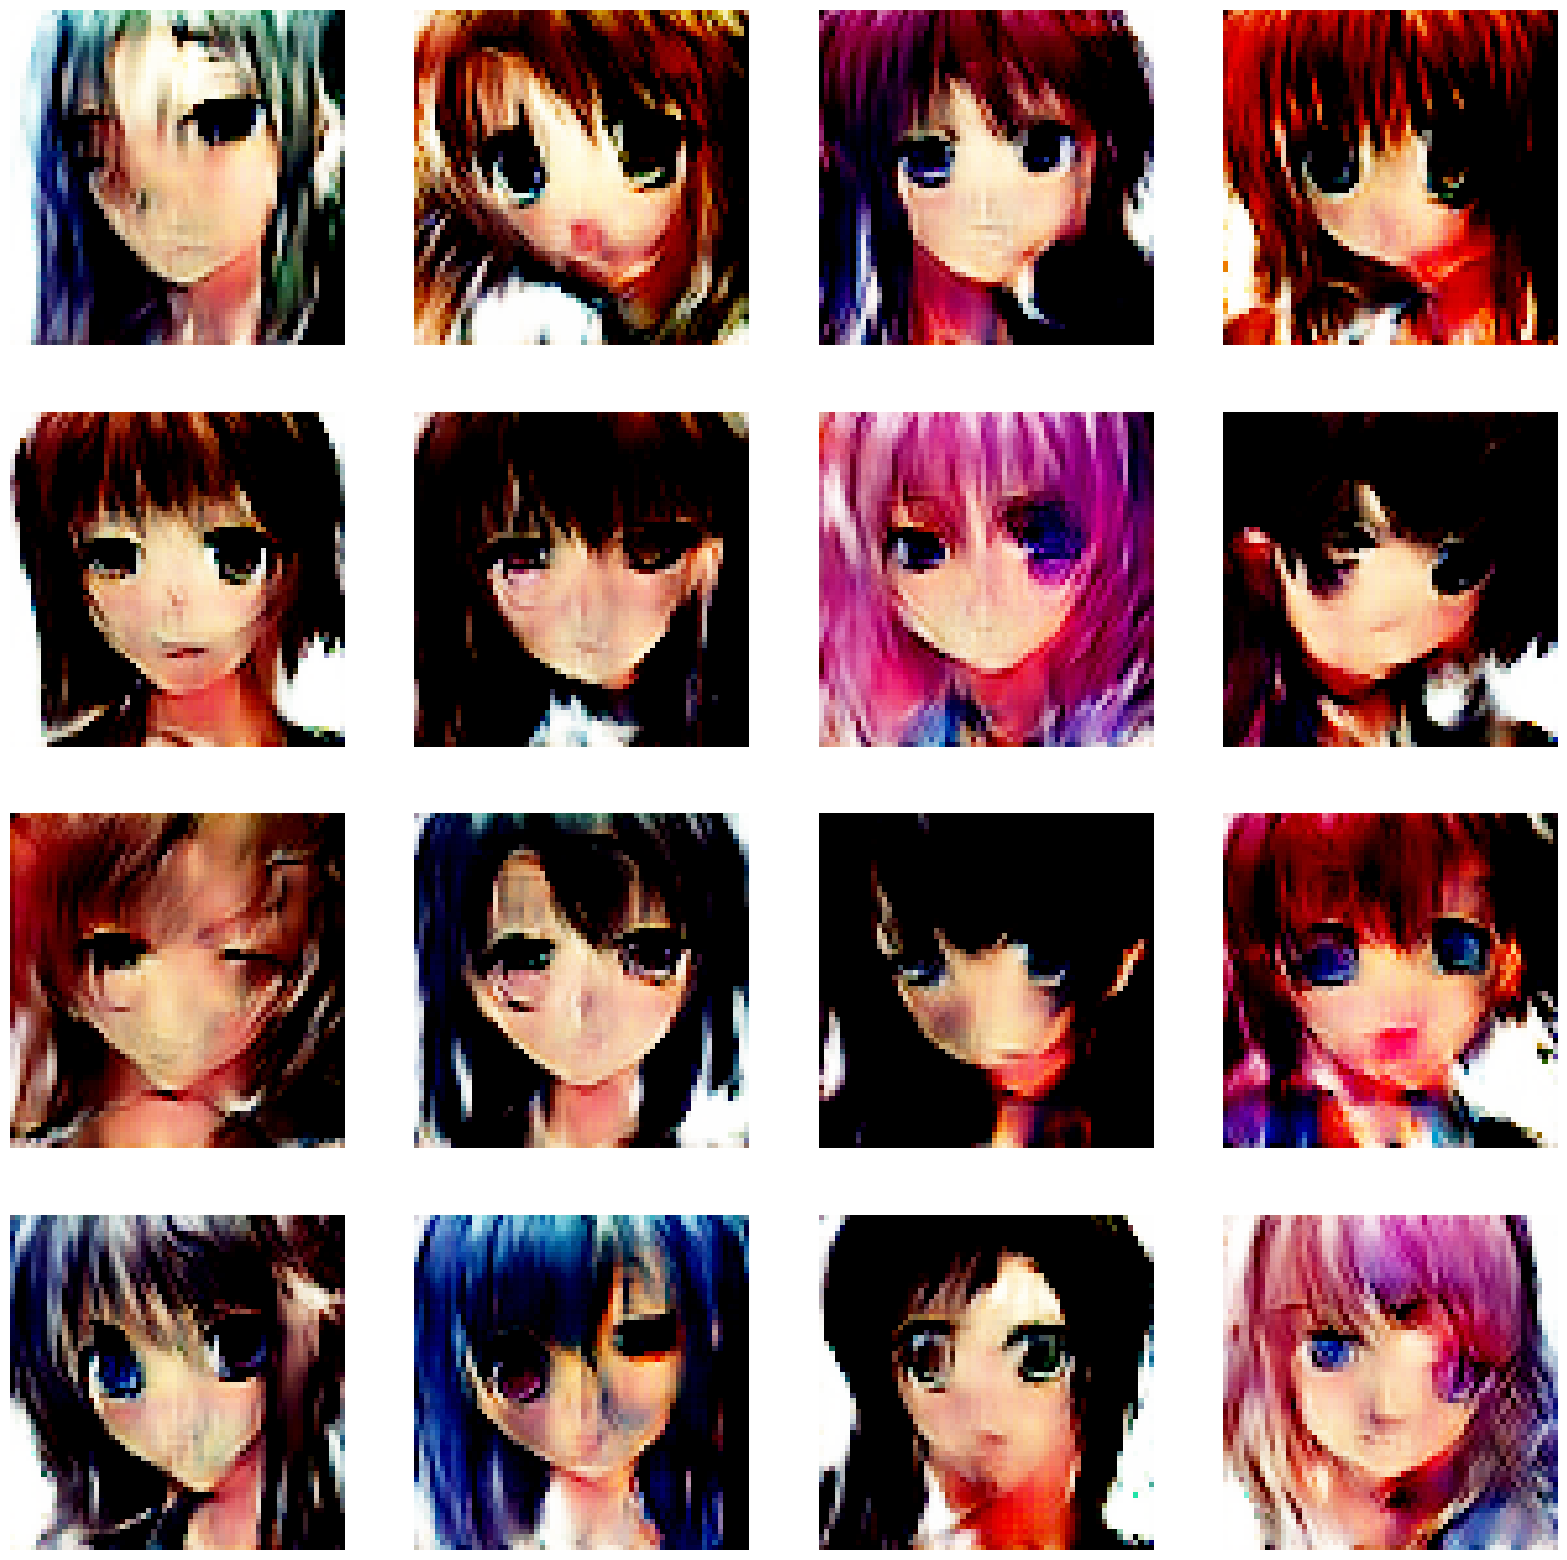

In [61]:
plt.figure(figsize = (20,20))

i = 0

while i < 16 :
    
    plt.subplot(4, 4, i+1)
    plt.imshow(gen_img[i])
    plt.axis('off')
    i += 1